# PyDevice IOC calculation

In [20]:
import epics
import numpy as np
import matplotlib.pyplot as plt
import time

In [21]:
energy_list = [i for i in range(6,26)]
energies = np.asarray(energy_list)

In [46]:
slitH = epics.caget("100idPyCRL:testSSH.VAL")
slitV = epics.caget("100idPyCRL:testSSV.VAL")
print(f'Horizontal slits size: {slitH} m\nVertical slit size: {slitV} m')

Horizontal slits size: 0.0005 m
Vertical slit size: 0.0003 m


In [47]:
fSize_array = np.empty([len(energy_list),1024])
for i in energies:
    epics.caput("100idPyCRL:testMonoE.VAL",float(i))
    time.sleep(1)
    fSize_array[i-6,:]=epics.caget("100idPyCRL:CRL1:fSizes")

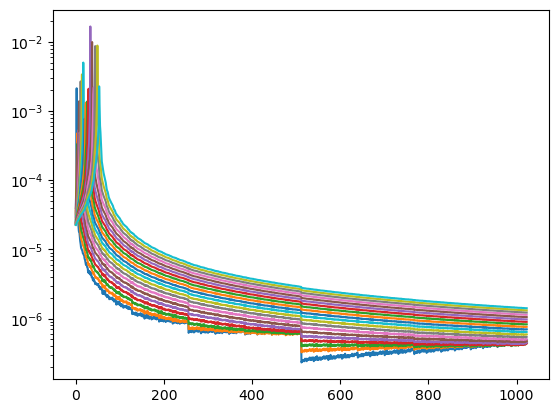

In [48]:
plt.plot(np.linspace(0,1023,1024), fSize_array.T)
plt.yscale('log')
plt.show()

# Xianbo Calculation

In [49]:
from scipy.optimize import root_scalar
import xraylib

In [50]:
# Lookup table where each entry is a tuple (column1, column2)
Lens_diameter_table = [
    (50, 450.0),
    (100, 632.0),
    (200, 894.0),
    (300, 1095.0),
    (500, 1414.0),
    (1000, 2000.0),
    (1500, 2450.0),
    ]

# Convert the lookup table to a dictionary for faster lookup
Lens_diameter_dict = {int(col1): col2 for col1, col2 in Lens_diameter_table}

In [51]:
def lookup_diameter(lens_radius):
    # Convert the input float to an integer
    input_int = int(round(lens_radius*1.0e6))
    return Lens_diameter_dict.get(input_int, (lens_radius*1.0e6)**0.5*63.222+ 0.73)/1.0e6

In [52]:
def index_to_binary_list(index, length):
    """
    Converts an index number to its binary representation as a list of digits,
    and pads the list with zeros in front to achieve the desired length.

    Parameters:
        index (int): The index number to be converted.
        length (int): The desired length of the binary list.

    Returns:
        list: A list of digits representing the binary representation of the index.
    """
    # Convert the index to a binary string and remove the '0b' prefix
    binary_str = bin(index)[2:]

    # Pad the binary string with zeros in front to achieve the desired length
    #padded_binary_str = binary_str.zfill(length)

    # Reverse the binary string
    reversed_binary_str = binary_str[::-1]

    # Convert the reversed binary string to a list of integers
    binary_list = [int(digit) for digit in reversed_binary_str]

    # Pad the list with zeros at the end to achieve the desired length
    while len(binary_list) < length:
        binary_list.append(0)

    return binary_list

In [53]:
def binary_list_to_index(binary_list, length):
    """
    Converts a list of binary digits in reverse order to its integer representation,
    padding the list with zeros at the end to have a fixed number of elements.

    Parameters:
        binary_list (list): A list of digits representing the binary number in reverse order.
        length (int): The fixed number of elements the list should have.

    Returns:
        int: The integer representation of the binary number.
    """
    # Pad the list with zeros at the end to achieve the desired length
    while len(binary_list) < length:
        binary_list.append(0)

    # Convert the binary list to an integer
    index = 0
    for i, digit in enumerate(binary_list):
        index += digit * 2**i

    return index

In [54]:
def materials_to_deltas(material_list, energy):
    """
    Convert a list of material names to a list of delta values at a given energy.
    Parameters:
        material_list (list): A list of material names.
        energy (float): The energy in keV.
    Returns:
        list: A list of delta values for the given materials at the given energy.
    """

    # The list to store delta values
    delta_list = []

    # Iterate through each material in the input list
    for material in material_list:
        # Compute the delta value for the current material at the given energy
        Z = xraylib.SymbolToAtomicNumber(material)
        density = xraylib.ElementDensity(Z)
        delta = 1.0-xraylib.Refractive_Index_Re(material, energy, density)

        # Add the delta value to the delta list
        delta_list.append(delta)

    return delta_list

In [55]:
def materials_to_linear_attenuation(material_list, energy):
    """
    Convert a list of material names to a list of linear attenuation coefficients at a given energy.
    Parameters:
        material_list (list): A list of material names.
        energy (float): The energy in keV.

    Returns:
        list: A list of linear attenuation coefficient values (in m^-1) for the given materials at the given energy.
    """
    # The list to store linear attenuation coefficient values
    mu_list = []

    # Iterate through each material in the input list
    for material in material_list:
        # Compute the delta value for the current material at the given energy
        Z = xraylib.SymbolToAtomicNumber(material)
        density = xraylib.ElementDensity(Z)

        # Compute the mass attenuation coefficient in cm^2/g
        #mass_attenuation = xraylib.CS_Photo(Z, energy)
        mass_attenuation = xraylib.CS_Total(Z, energy)

        # Convert mass attenuation coefficient to linear attenuation coefficient in m^-1
        mu = mass_attenuation * density * 100.0       

        # Add the linear attenuation coefficient value to the list
        mu_list.append(mu)
 
    return mu_list

In [56]:
def absorptionaperture(x, n1mud, sigma, n1mur):

    numerator = np.exp(-(x**2/(2*sigma**2))) * np.exp(-n1mur*(x**2) - n1mud)
    denominator = np.exp(-n1mud)

    return numerator / denominator - 0.5

In [57]:
def fSize_xs(energy, slit1_H = 500.0e-6, slit1_V = 300.0e-6, flag_HE = False):
    '''
    energy [eV]
    slit1_H [m]
    slit1_v [m]
    '''    
    
    energy_keV = energy/1000.0  # Energy in keV
    wl = 1239.84 / (energy * 10**9)
    d_StoL1 = 51.9              # Source-to-CRL1 distance, in m
    d_StoL2 = 62.1              # Source-to-CRL2 distance, in m
    d_Stof  = 66.2              # Source-to-focus distance, in m

#    slit1_H = 500.0e-6          # H slit size before CRL 1
#    slit1_V = 300.0e-6          # V slit size before CRL 1

    # CRL input block
    d_min   = 3.0e-5            # Minimum thickness at the apex in m
    stack_d = 50.0e-3           # Stack thickness in m
    L1_n    = np.array([1,      1,      1,      1,      1,      1,      2,      4,      8,      16])                # CRL1 number of lenses in each stack
    L1_R    = np.array([2.0e-3, 1.0e-3, 5.0e-4, 3.0e-4, 2.0e-4, 1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4])            # CRL1 lens radius in each stack
    L1_mater= np.array(["Be",   "Be",   "Be",   "Be",   "Be",   "Be",   "Be",   "Be",   "Be",   "Be"])              # CRL1 lens material in each stack
    L1_loc  = np.array([4.5,    3.5,    2.5,    1.5,    0.5,    -0.5,   -1.5,   -2.5,   -3.5,   -4.5])*stack_d      # CRL1 lens stack location relative to center stack, positive means upstream
    L1_HE   = np.array([1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.4e-6, 2.0e-6, 2.8e-6, 4.0e-6])            # CRL1 lens RMS thickness error

    # Source size input block
    L_und = 4.7                 # undulator length
    sigmaH_e = 14.8e-6          # Sigma electron source size in H direction in m
    sigmaV_e = 3.7e-6           # Sigma electron source size in V direction in m
    sigmaHp_e = 2.8e-6          # Sigma electron divergence in H direction in rad
    sigmaVp_e = 1.5e-6          # Sigma electron divergence in V direction in rad

    sigmaH = (sigmaH_e**2 + wl*L_und/2/np.pi/np.pi)**0.5
    sigmaV = (sigmaV_e**2 + wl*L_und/2/np.pi/np.pi)**0.5
    sigmaHp = (sigmaHp_e**2 + wl/L_und/2)**0.5
    sigmaVp = (sigmaVp_e**2 + wl/L_und/2)**0.5
    L1_D        = np.zeros(L1_R.size)                                   # CRL1 diameters for each stack
    for i in range(L1_R.size):
        L1_D[i] = lookup_diameter(L1_R[i])
    L1_delta    = materials_to_deltas(L1_mater, energy_keV)             # delta values for CRL1 stacks
    L1_mu       = materials_to_linear_attenuation(L1_mater, energy_keV) # mu values for CRL1 stacks
    L1_Feq      = L1_R/(2*L1_n*L1_delta) + L1_loc                       # CRL1 equivalent f in m for each stack
    L1_index_n  = 2**L1_Feq.size                                        # Total number of combinations for CRL1
    L1_invF_list= np.zeros(L1_index_n)                                  # List of equivalent 1/f in m^-1 for CRL1
    for i in range(L1_index_n):
        L1_invF_list[i] = np.sum(index_to_binary_list(i, L1_Feq.size)/L1_Feq)

    # Sort the L1_invF list (to avoid zigzagging)
    L1_invF_list_sort_indices = np.argsort(L1_invF_list)
    L1_invF_list_sorted       = L1_invF_list[L1_invF_list_sort_indices]
    q1_list  = 1/(L1_invF_list_sorted - 1/d_StoL1)      # focal position of CRL1 for all configurations (sorted)
    dq1_list = q1_list - (d_Stof - d_StoL1)

    # Start generating focal size list as a function of CRL1 setting
    sigma1H         = (sigmaH**2 + (sigmaHp*d_StoL1)**2)**0.5   # sigma beam size before CRL1
    sigma1V         = (sigmaV**2 + (sigmaVp*d_StoL1)**2)**0.5   # sigma beam size before CRL1
    L1_n1mud_list   = np.zeros(L1_index_n)                      # List of n1*mu*d_min for all possible CRL1 configurations
    L1_n1muR_list   = np.zeros(L1_index_n)                      # List of n1*mu/R for all possible CRL1 configurations
    aperL1H_list    = np.zeros(L1_index_n)                      # absorption H aperture of CRL1 for all configurations
    aperL1V_list    = np.zeros(L1_index_n)                      # absorption V aperture of CRL1 for all configurations
    diameter1_list  = np.zeros(L1_index_n)                      # CRL1 diameter for all possible configurations
    FWHM1H_list     = np.zeros(L1_index_n)                      # H focal size at the focus of CRL1
    FWHM1V_list     = np.zeros(L1_index_n)                      # V focal size at the focus of CRL1
    Strehl_list     = np.zeros(L1_index_n)                      # Strehl ratio based on lens thickness error

    for i in range(L1_index_n):
        # absorption aperture is a function of CRL absorption/physical aperture, incident beam size, and physical slits
        L1_n1mud_list[i] = np.sum(index_to_binary_list(L1_invF_list_sort_indices[i], L1_Feq.size)*np.array(L1_mu*L1_n*d_min))
        L1_n1muR_list[i] = np.sum(index_to_binary_list(L1_invF_list_sort_indices[i], L1_Feq.size)*np.array(L1_mu*L1_n/L1_R))
        solution = root_scalar(absorptionaperture, args=(L1_n1mud_list[i], sigma1H, L1_n1muR_list[i]), bracket=[0.0, 2*sigma1H], method='bisect')
        aperL1H_list[i] = solution.root*2.0
        solution = root_scalar(absorptionaperture, args=(L1_n1mud_list[i], sigma1V, L1_n1muR_list[i]), bracket=[0.0, 2*sigma1V], method='bisect')
        aperL1V_list[i] = solution.root*2.0
        mask = (np.array(index_to_binary_list(L1_invF_list_sort_indices[i], L1_Feq.size)) == 1)

        if np.all(mask == False):
            diameter1_list[i] = np.inf
        else:
            diameter1_list[i] = np.min(L1_D[mask])
        aperL1H_list[i] = min(aperL1H_list[i], diameter1_list[i], slit1_H)
        aperL1V_list[i] = min(aperL1V_list[i], diameter1_list[i], slit1_V)

        phase_error_tmp = np.linalg.norm(index_to_binary_list(L1_invF_list_sort_indices[i], L1_Feq.size)*np.array(L1_HE*L1_delta)*2*np.pi/wl)
        Strehl_list[i] = np.exp(-phase_error_tmp**2)

    # FWHMbeam size at CRL1 focus
    FWHM1H_list  = ((0.88*wl*q1_list/aperL1H_list)**2 + (2.355*sigmaH*q1_list/d_StoL1)**2)**0.5
    FWHM1V_list  = ((0.88*wl*q1_list/aperL1V_list)**2 + (2.355*sigmaV*q1_list/d_StoL1)**2)**0.5
    if flag_HE:
        FWHM1H_list *= (Strehl_list)**(-0.5)
        FWHM1V_list *= (Strehl_list)**(-0.5)
    FWHM_list   = (FWHM1H_list*FWHM1V_list)**0.5

    return FWHM_list


In [58]:
fSize_array_xs = np.empty([len(energy_list),1024])
for i in energies:
    fSize_array_xs[i-6,:]=fSize_xs(i*1000.0, slit1_H = slitH, slit1_V = slitV)

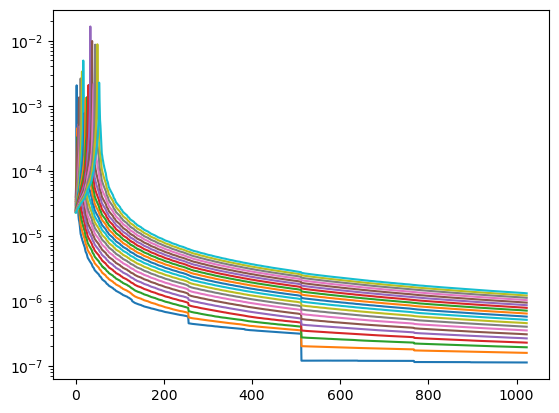

In [59]:
plt.plot(np.linspace(0,1023,1024), fSize_array_xs.T)
plt.yscale('log')
plt.show()

# Comparison

## 100 um x 100 um

In [103]:
slitH = 0.0005
slitV = 0.0003

epics.caput("100idPyCRL:testSSH.VAL", slitH)
epics.caput("100idPyCRL:testSSV.VAL", slitV)

energy_list = [i for i in range(6,26)]
energies = np.asarray(energy_list)

fSize_array_A = np.empty([len(energy_list),1024])
fSize_array_xs_A = np.empty([len(energy_list),1024])
for i in energies:
    epics.caput("100idPyCRL:testMonoE.VAL",float(i))
    time.sleep(1)
    fSize_array_A[i-6,:]=epics.caget("100idPyCRL:CRL1:fSizes")
    fSize_array_xs_A[i-6,:]=fSize_xs(i*1000.0, slit1_H = slitH, slit1_V = slitV)
ratio_A = fSize_array_A/fSize_array_xs_A

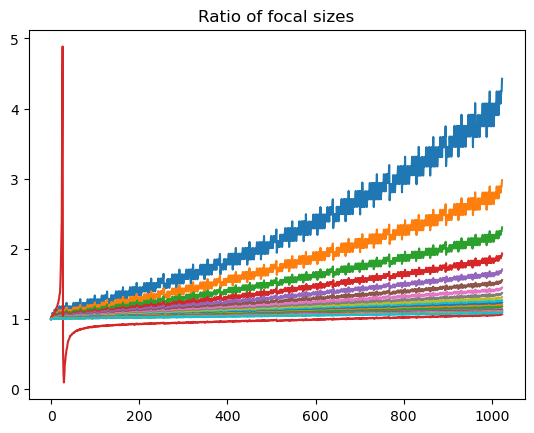

In [123]:
plt.plot(np.linspace(0,1023,1024), ratio_A.T)
plt.title('Ratio of focal sizes')
plt.show()

In [105]:
# 6 keV -- low bit configurations
print(fSize_array_A[0,0:9])
print(fSize_array_xs_A[0,0:9])

[3.96359250e-05 8.11586911e-05 2.13685905e-03 9.13301785e-05
 4.31033834e-05 2.97138338e-05 2.22095595e-05 1.82474532e-05
 1.84746369e-05]
[3.96359250e-05 7.78567370e-05 2.04992061e-03 8.40497905e-05
 4.13497155e-05 2.73451946e-05 2.04391237e-05 1.75050527e-05
 1.63102045e-05]


In [106]:
# 6 keV -- high bit configurations
print(fSize_array_A[0,1014:1023])
print(fSize_array_xs_A[0,1014:1023])

[4.57057325e-07 4.38440384e-07 4.76404009e-07 4.56998934e-07
 4.56963588e-07 4.76305908e-07 4.56893555e-07 4.76232613e-07
 4.76195201e-07]
[1.12268528e-07 1.12263025e-07 1.12259713e-07 1.12254185e-07
 1.12245503e-07 1.12236596e-07 1.12228300e-07 1.12219325e-07
 1.12210509e-07]


In [107]:
# 25 keV
print(fSize_array_A[19,0:9])
print(fSize_array_xs_A[19,0:9])

[2.25635626e-05 2.32757846e-05 2.39735358e-05 2.47734837e-05
 2.55023578e-05 2.64053431e-05 2.73047089e-05 2.78724266e-05
 2.83350772e-05]
[2.25635626e-05 2.32203743e-05 2.39164644e-05 2.46556726e-05
 2.54416469e-05 2.62797717e-05 2.71748605e-05 2.78060735e-05
 2.81331952e-05]


In [108]:
# 25 keV -- high bit configurations
print(fSize_array_A[19,1014:1023])
print(fSize_array_xs_A[19,1014:1023])

[1.42470707e-06 1.41982510e-06 1.42586097e-06 1.42097752e-06
 1.41874935e-06 1.41990829e-06 1.41431496e-06 1.41547759e-06
 1.41327267e-06]
[1.31443386e-06 1.31305562e-06 1.31236677e-06 1.31099297e-06
 1.30893727e-06 1.30688790e-06 1.30484610e-06 1.30280988e-06
 1.30078046e-06]


## 500 um x 300 um

In [109]:
slitH = 0.0005
slitV = 0.0003

epics.caput("100idPyCRL:testSSH.VAL", slitH)
epics.caput("100idPyCRL:testSSV.VAL", slitV)

energy_list = [i for i in range(6,26)]
energies = np.asarray(energy_list)

fSize_array_B = np.empty([len(energy_list),1024])
fSize_array_xs_B = np.empty([len(energy_list),1024])
for i in energies:
    epics.caput("100idPyCRL:testMonoE.VAL",float(i))
    time.sleep(1)
    fSize_array_B[int(i-6),:]=epics.caget("100idPyCRL:CRL1:fSizes")
    fSize_array_xs_B[i-6,:]=fSize_xs(i*1000.0, slit1_H = slitH, slit1_V = slitV)
ratio_B = fSize_array_B/fSize_array_xs_B

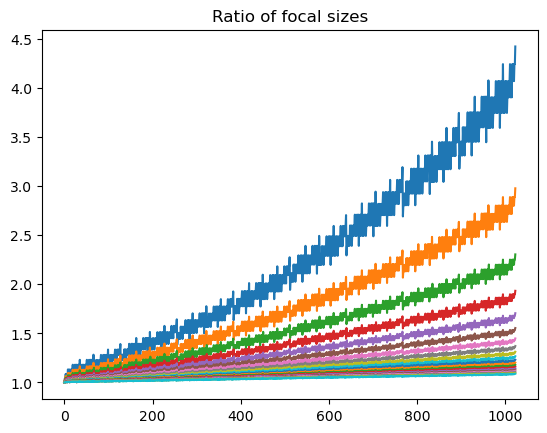

In [122]:
plt.plot(np.linspace(0,1023,1024), ratio_B.T)
plt.title('Ratio of focal sizes')

plt.show()

In [111]:
# 6 keV -- low bit configurations
print(fSize_array_B[0,0:9])
print(fSize_array_xs_B[0,0:9])

[3.96359250e-05 8.11586911e-05 2.13685905e-03 9.13301785e-05
 4.31033834e-05 2.97138338e-05 2.22095595e-05 1.82474532e-05
 1.84746369e-05]
[3.96359250e-05 7.78567370e-05 2.04992061e-03 8.40497905e-05
 4.13497155e-05 2.73451946e-05 2.04391237e-05 1.75050527e-05
 1.63102045e-05]


In [112]:
# 6 keV -- high bit configurations
print(fSize_array_B[0,1014:1023])
print(fSize_array_xs_B[0,1014:1023])

[4.57057325e-07 4.38440384e-07 4.76404009e-07 4.56998934e-07
 4.56963588e-07 4.76305908e-07 4.56893555e-07 4.76232613e-07
 4.76195201e-07]
[1.12268528e-07 1.12263025e-07 1.12259713e-07 1.12254185e-07
 1.12245503e-07 1.12236596e-07 1.12228300e-07 1.12219325e-07
 1.12210509e-07]


In [113]:
# 25 keV
print(fSize_array_B[19,0:9])
print(fSize_array_xs_B[19,0:9])

[2.25635626e-05 2.32757846e-05 2.39735358e-05 2.47734837e-05
 2.55023578e-05 2.64053431e-05 2.73047089e-05 2.78724266e-05
 2.83350772e-05]
[2.25635626e-05 2.32203743e-05 2.39164644e-05 2.46556726e-05
 2.54416469e-05 2.62797717e-05 2.71748605e-05 2.78060735e-05
 2.81331952e-05]


In [114]:
# 25 keV -- high bit configurations
print(fSize_array_B[19,1014:1023])
print(fSize_array_xs_B[19,1014:1023])

[1.42470707e-06 1.41982510e-06 1.42586097e-06 1.42097752e-06
 1.41874935e-06 1.41990829e-06 1.41431496e-06 1.41547759e-06
 1.41327267e-06]
[1.31443386e-06 1.31305562e-06 1.31236677e-06 1.31099297e-06
 1.30893727e-06 1.30688790e-06 1.30484610e-06 1.30280988e-06
 1.30078046e-06]


## 1 mm x 0.5 mm

In [115]:
slitH = 0.001
slitV = 0.0005

epics.caput("100idPyCRL:testSSH.VAL", slitH)
epics.caput("100idPyCRL:testSSV.VAL", slitV)

energy_list = [i for i in range(6,26)]
energies = np.asarray(energy_list)

fSize_array_C = np.empty([len(energy_list),1024])
fSize_array_xs_C = np.empty([len(energy_list),1024])
for i in energies:
    epics.caput("100idPyCRL:testMonoE.VAL",float(i))
    time.sleep(1)
    fSize_array_C[i-6,:]=epics.caget("100idPyCRL:CRL1:fSizes")
    fSize_array_xs_C[i-6,:]=fSize_xs(i*1000.0, slit1_H = slitH, slit1_V = slitV)
ratio_C = fSize_array_C/fSize_array_xs_C

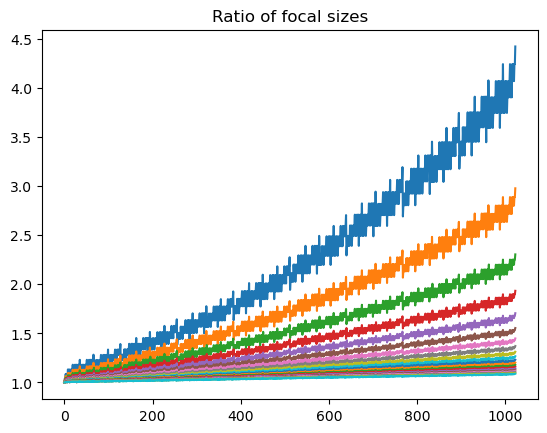

In [121]:
plt.plot(np.linspace(0,1023,1024), ratio_C.T)
plt.title('Ratio of focal sizes')
plt.show()

In [117]:
# 6 keV -- low bit configurations
print(fSize_array_C[0,0:9])
print(fSize_array_xs_C[0,0:9])

[3.30244657e-05 6.76960973e-05 1.78436684e-03 7.63484335e-05
 3.60722018e-05 2.48939248e-05 1.86271309e-05 1.53151542e-05
 1.55114085e-05]
[3.30244657e-05 6.49418710e-05 1.71176959e-03 7.02623157e-05
 3.46045987e-05 2.29095048e-05 1.71422686e-05 1.46920547e-05
 1.36941389e-05]


In [118]:
# 6 keV -- high bit configurations
print(fSize_array_C[0,1014:1023])
print(fSize_array_xs_C[0,1014:1023])

[4.57057325e-07 4.38440384e-07 4.76404009e-07 4.56998934e-07
 4.56963588e-07 4.76305908e-07 4.56893555e-07 4.76232613e-07
 4.76195201e-07]
[1.12268528e-07 1.12263025e-07 1.12259713e-07 1.12254185e-07
 1.12245503e-07 1.12236596e-07 1.12228300e-07 1.12219325e-07
 1.12210509e-07]


In [119]:
# 25 keV
print(fSize_array_C[19,0:9])
print(fSize_array_xs_C[19,0:9])

[2.22315851e-05 2.29343472e-05 2.36229123e-05 2.44122448e-05
 2.51316067e-05 2.60226199e-05 2.69101446e-05 2.74704714e-05
 2.79268631e-05]
[2.22315851e-05 2.28797497e-05 2.35666756e-05 2.42961516e-05
 2.50717785e-05 2.58988685e-05 2.67821726e-05 2.74050752e-05
 2.77278895e-05]


In [120]:
# 25 keV -- high bit configurations
print(fSize_array_C[19,1014:1023])
print(fSize_array_xs_C[19,1014:1023])

[1.42470707e-06 1.41982510e-06 1.42586097e-06 1.42097752e-06
 1.41874935e-06 1.41990829e-06 1.41431496e-06 1.41547759e-06
 1.41327267e-06]
[1.31443386e-06 1.31305562e-06 1.31236677e-06 1.31099297e-06
 1.30893727e-06 1.30688790e-06 1.30484610e-06 1.30280988e-06
 1.30078046e-06]


# Slit size comparsion
## IOC code

## XS code

# Sorted focal size comparison
Sorting the focal sizes

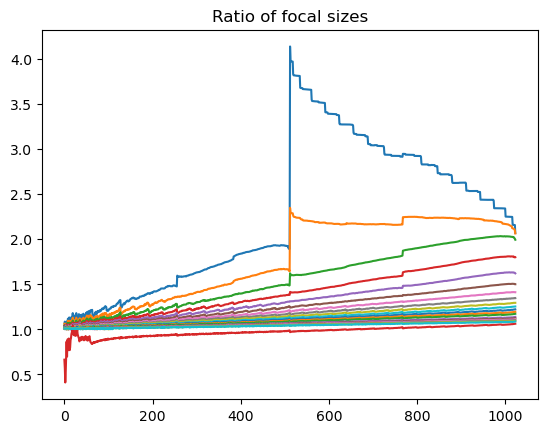

In [130]:
ratio_A_sorted = np.flip(np.sort(fSize_array_A)/np.sort(fSize_array_xs_A),axis=1)
plt.plot(np.linspace(0,1023,1024), ratio_A_sorted.T)
plt.title('Ratio of focal sizes')
plt.show()

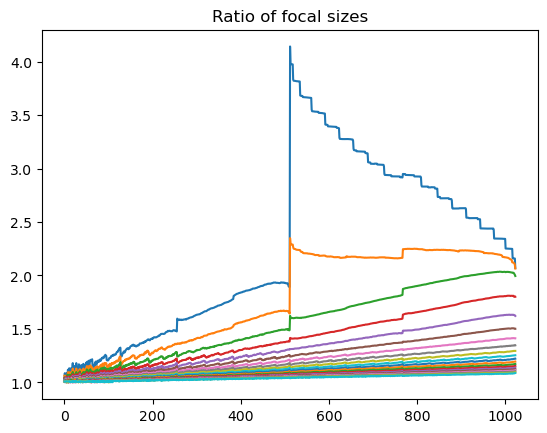

In [129]:
ratio_B_sorted = np.flip(np.sort(fSize_array_B)/np.sort(fSize_array_xs_B), axis = 1)
plt.plot(np.linspace(0,1023,1024), ratio_B_sorted.T)
plt.title('Ratio of focal sizes')
plt.show()

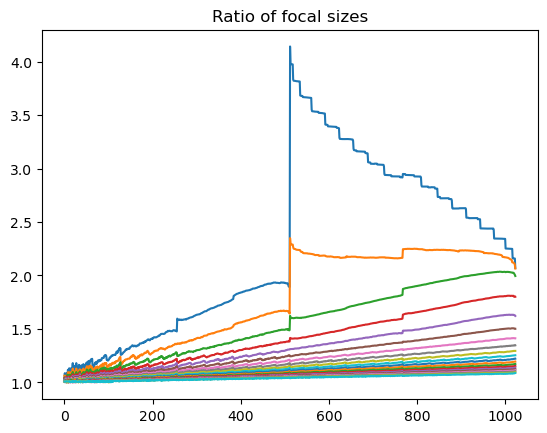

In [131]:
ratio_C_sorted = np.flip(np.sort(fSize_array_C)/np.sort(fSize_array_xs_C),axis=1)
plt.plot(np.linspace(0,1023,1024), ratio_C_sorted.T)
plt.title('Ratio of focal sizes')
plt.show()